### ResNet

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch as th
import torch.nn as nn
from dataset import mnist
from util import (
    get_torch_size_string,
    print_model_parameters,
    print_model_layers,
    model_train,
    model_eval,
    model_test
)
np.set_printoptions(precision=3)
th.set_printoptions(precision=3)
%matplotlib inline
%config InlineBackend.figure_format='retina'
print ("PyTorch version:[%s]."%(th.__version__))

PyTorch version:[2.0.1].


### Hyperparameters

In [2]:
device      = 'cpu' # cpu / mps
n_epoch     = 1
batch_size  = 128
print_every = 1
print ("Ready.")

Ready.


### Dataset

In [3]:
train_iter,test_iter,train_data,train_label,test_data,test_label = \
    mnist(root_path='../data',batch_size=128)
print ("MNIST ready.")

MNIST ready.


### Residual Block

In [4]:
class Residual(nn.Module):
    """The Residual block of ResNet models.""" 
    def __init__(self, num_channels, use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.LazyConv2d(
            num_channels, kernel_size=3, padding=1,stride=strides)
        self.conv2 = nn.LazyConv2d(
            num_channels, kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.LazyConv2d(num_channels, kernel_size=1,
                stride=strides)
        else:
            self.conv3 = None 
        self.bn1  = nn.LazyBatchNorm2d() 
        self.bn2  = nn.LazyBatchNorm2d()
        self.actv = nn.ReLU()
    def forward(self,x):
        y = self.actv(self.bn1(self.conv1(x))) 
        y = self.bn2(self.conv2(y)) 
        if self.conv3:
            x = self.conv3(x) 
        y += x 
        return self.actv(y)
print ("Ready.")

Ready.


### Check ResBlocks

In [5]:
resblock = Residual(num_channels=3,use_1x1conv=False,strides=1)
x_torch = th.randn(16,3,224,224)
y_torch = resblock(x_torch,)
print ("x_torch:[%s] => y_torch:[%s]"%
       (get_torch_size_string(x_torch),get_torch_size_string(y_torch)))

x_torch:[16x3x224x224] => y_torch:[16x3x224x224]


/Users/sj/anaconda3/envs/mujoco/lib/python3.9/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [6]:
resblock = Residual(num_channels=3,use_1x1conv=True,strides=1)
x_torch = th.randn(16,3,224,224)
y_torch = resblock(x_torch,)
print ("x_torch:[%s] => y_torch:[%s]"%
       (get_torch_size_string(x_torch),get_torch_size_string(y_torch)))

x_torch:[16x3x224x224] => y_torch:[16x3x224x224]


In [7]:
resblock = Residual(num_channels=3,use_1x1conv=True,strides=2)
x_torch = th.randn(16,3,224,224)
y_torch = resblock(x_torch,)
print ("x_torch:[%s] => y_torch:[%s]"%
       (get_torch_size_string(x_torch),get_torch_size_string(y_torch)))

x_torch:[16x3x224x224] => y_torch:[16x3x112x112]


### ResNet

In [8]:
class ResNetClass(nn.Module):
    
    def __init__(
        self,
        name,
        arch,
        x_dim       = (1,28,28),
        num_classes = 10
    ):
        super(ResNetClass, self).__init__()
        self.name        = name
        self.arch        = arch
        self.x_dim       = x_dim
        self.num_classes = num_classes
        
        self.net = nn.Sequential(self.b1())
        for i, b in enumerate(self.arch):
            self.net.add_module(f'b{i+2}', self.block(*b, first_block=(i==0)))
        self.net.add_module('last', nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)), nn.Flatten(),
            nn.LazyLinear(self.num_classes)))
        
        self.layer_names = []
        for l_idx,layer in enumerate(self.net):
            layer_name = "%s_%02d"%(type(layer).__name__.lower(),l_idx)
            self.layer_names.append(layer_name)
        
    def b1(self):
        return nn.Sequential(
            nn.LazyConv2d(64, kernel_size=7, stride=2, padding=3),
            nn.LazyBatchNorm2d(), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
    
    def block(self, num_residuals, num_channels, first_block=False):
        blk = []
        for i in range(num_residuals):
            if i == 0 and not first_block:
                blk.append(Residual(num_channels, use_1x1conv=True, strides=2)) 
            else:
                blk.append(Residual(num_channels)) 
        return nn.Sequential(*blk)
    
    def init_param(self,VERBOSE=False):
        """
            Initialize parameters
        """
        for m_idx,m in enumerate(self.modules()):
            if VERBOSE:
                print ("[%02d]"%(m_idx))
            if isinstance(m,nn.Conv2d): # init conv
                nn.init.kaiming_normal_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m,nn.LazyConv2d): # init conv
                nn.init.kaiming_normal_(m.weight)
                nn.init.zeros_(m.bias)
            elif isinstance(m,nn.BatchNorm1d) or isinstance(m,nn.BatchNorm2d): 
                nn.init.constant_(m.weight,1.0)
                nn.init.constant_(m.bias,0.0)
            elif isinstance(m,nn.Linear): # lnit dense
                nn.init.kaiming_normal_(m.weight,nonlinearity='relu')
                nn.init.zeros_(m.bias)
            elif isinstance(m,nn.LazyLinear): # lnit dense
                nn.init.kaiming_normal_(m.weight,nonlinearity='relu')
                nn.init.zeros_(m.bias)
    
    def forward(self,x):
        """
            Forward propagate
        """
        intermediate_output_list = []
        for layer in self.net:
            x = layer(x)
            intermediate_output_list.append(x)
        final_output = x
        return final_output,intermediate_output_list
    
print ("Ready.")

Ready.


In [9]:
resnet = ResNetClass(
    name        = 'resnet',
    arch        = ((2, 64), (2, 128), (2, 256), (2, 512)),
    x_dim       = (1,28,28),
    num_classes = 10
).to(device)
loss = nn.CrossEntropyLoss()
optm = th.optim.Adam(resnet.parameters(),lr=1e-3)
print ("Ready.")

Ready.


### Print model layers

In [10]:
x_torch = th.randn((16,)+resnet.x_dim).to(device)
print_model_layers(resnet,x_torch)

batch_size:[16]
[  ] layer:[          input] size:[    16x1x28x28]
[ 0] layer:[  sequential_00] size:[     16x64x7x7] numel:[     50176]
[ 1] layer:[  sequential_01] size:[     16x64x7x7] numel:[     50176]
[ 2] layer:[  sequential_02] size:[    16x128x4x4] numel:[     32768]
[ 3] layer:[  sequential_03] size:[    16x256x2x2] numel:[     16384]
[ 4] layer:[  sequential_04] size:[    16x512x1x1] numel:[      8192]
[ 5] layer:[  sequential_05] size:[         16x10] numel:[       160]


### Print model parameters

In [11]:
print_model_parameters(resnet)

[ 0] parameter:[             net.0.0.weight] shape:[    64x1x7x7] numel:[      3136]
[ 1] parameter:[               net.0.0.bias] shape:[          64] numel:[        64]
[ 2] parameter:[             net.0.1.weight] shape:[          64] numel:[        64]
[ 3] parameter:[               net.0.1.bias] shape:[          64] numel:[        64]
[ 4] parameter:[      net.b2.0.conv1.weight] shape:[   64x64x3x3] numel:[     36864]
[ 5] parameter:[        net.b2.0.conv1.bias] shape:[          64] numel:[        64]
[ 6] parameter:[      net.b2.0.conv2.weight] shape:[   64x64x3x3] numel:[     36864]
[ 7] parameter:[        net.b2.0.conv2.bias] shape:[          64] numel:[        64]
[ 8] parameter:[        net.b2.0.bn1.weight] shape:[          64] numel:[        64]
[ 9] parameter:[          net.b2.0.bn1.bias] shape:[          64] numel:[        64]
[10] parameter:[        net.b2.0.bn2.weight] shape:[          64] numel:[        64]
[11] parameter:[          net.b2.0.bn2.bias] shape:[          64]

### Train ResNet

In [12]:
model_train(resnet,optm,loss,train_iter,test_iter,n_epoch,print_every,device)

epoch:[ 0/1] loss:[0.168] train_accr:[0.9802] test_accr:[0.9770].


### Test ResNet

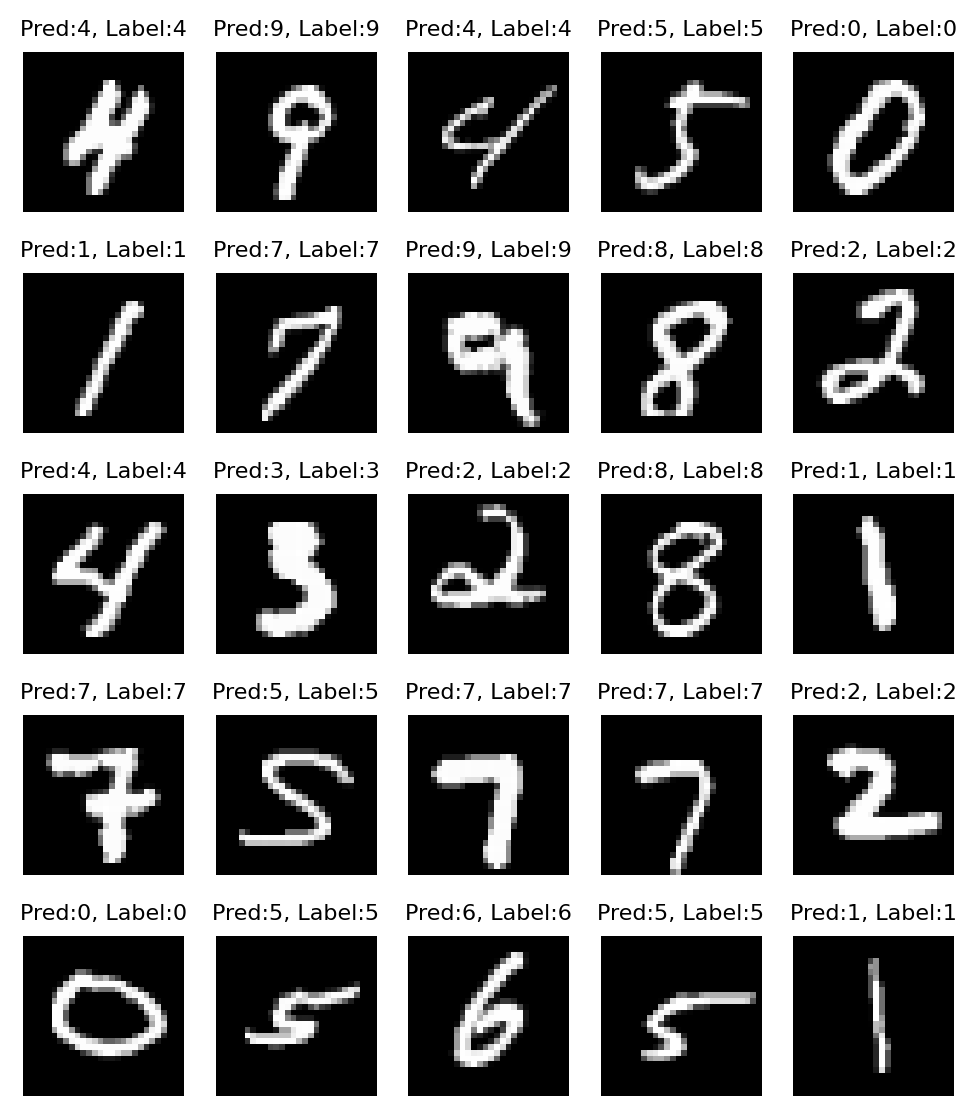

In [13]:
model_test(resnet,test_data,test_label,device)